In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
%env PYTHONHASHSEED=0

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session

# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

env: PYTHONHASHSEED=0



## Load Necessary Packages

In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, Conv1DTranspose, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ReLU, Masking, Concatenate, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Zeros
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.python.keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import lime.lime_tabular



from sklearn.model_selection import train_test_split

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# PREPROCESSING

In [4]:
# load data
meta = pd.read_csv("cdiff_meta_COMBINED.txt", sep = "\t")
fungi = pd.read_csv("filtered_species_table-FUNGI.txt", sep = "\t")
bacteria = pd.read_csv("filtered_species_table-NEW.txt", sep = "\t")

In [5]:
# transpose fungi data
fungi = fungi.set_index("SampleID")
fungi = fungi.transpose()
fungi.index = fungi.index.map(int)
fungi_names = fungi.columns

In [6]:
# sort by index
fungi = fungi.sort_index()

In [7]:
# transpose bacteria data
bacteria = bacteria.set_index("SampleID")
bacteria = bacteria.transpose()

In [8]:
# get sample indexes
sample_ids = list(bacteria.index)

In [9]:
# sort by index
bacteria.index = bacteria.index.map(int)
bacteria_names = bacteria.columns
bacteria = bacteria.sort_index()

In [10]:
meta = meta[meta["SampleID"].isin(sample_ids)]

In [11]:
# make output vector (positive/negative) from metadata
y = [1 if i == 'Positive' else 0 for i in meta["CDIStatus"]]
y = np.array(y)
y = y.astype("float32")

In [12]:
#convert to numpy array
fungi = np.array(fungi)
fungi = fungi.astype("float32")
bacteria = np.array(bacteria)
bacteria = bacteria.astype("float32")

## Fungi Expressed Taxa Data Analysis

Scores for each fold are: [0.75       0.25       1.         0.75       1.         0.75
 1.         1.         0.5        1.         1.         0.75
 0.5        0.5        1.         0.75       0.75       0.75
 1.         1.         0.75       1.         0.75       1.
 1.         0.         0.75       0.5        0.75       0.66666667
 0.75       0.5        0.75       0.5        0.75       0.5
 0.75       1.         1.         1.         1.         0.5
 0.75       1.         1.         0.5        0.25       0.5
 0.75       1.        ]
Average score: 0.758 (+/-0.240)


<AxesSubplot:ylabel='SampleID'>

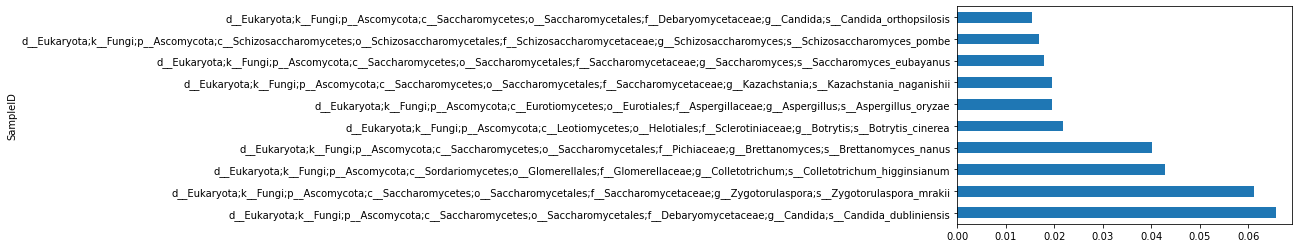

In [13]:
# Linear SVM
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

clf = svm.SVC(kernel='linear')
clf.fit(fungi, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, fungi, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.coef_[0]), index=fungi_names).nlargest(10).plot(kind='barh')

Scores for each fold are: [0.5        0.75       0.75       0.75       0.75       0.25
 0.5        0.75       0.75       1.         0.5        0.75
 0.5        0.75       0.5        0.75       0.75       0.75
 0.5        1.         0.75       1.         0.5        0.75
 0.75       0.5        0.75       0.25       0.5        1.
 0.75       0.75       0.5        0.5        0.5        0.75
 0.25       1.         0.5        0.66666667 1.         0.25
 0.75       0.75       0.75       1.         0.25       0.75
 0.75       0.66666667]
Average score: 0.667


<AxesSubplot:ylabel='SampleID'>

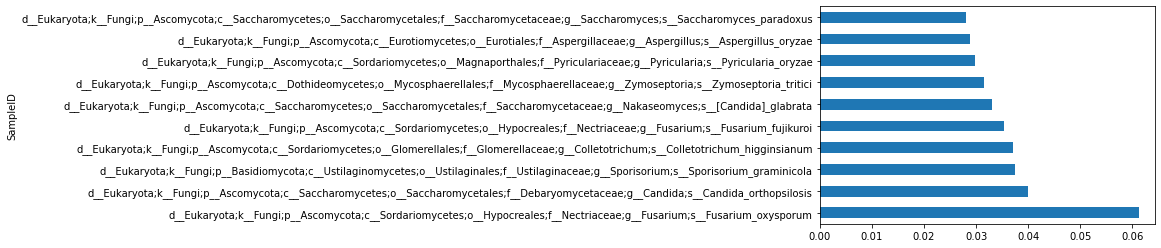

In [15]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(fungi, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, fungi, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=fungi_names).nlargest(10).plot(kind='barh')

In [ ]:
# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(fungi, y):
    
    model = Sequential([
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    model.fit(fungi[train], y[train],
              epochs = 1000,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(fungi[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} ".format(model.metrics_names[1], train_result[1]))
    
    result = model.evaluate(fungi[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1]))
    
    cvacc.append(result[1])
    
print("Accuracy: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc)))



## Bacteria Expressed Taxa Data Analysis

Scores for each fold are: [0.75       1.         0.25       0.5        0.75       0.5
 1.         0.5        0.5        1.         0.75       0.75
 0.75       0.5        1.         1.         0.25       0.5
 0.75       0.66666667 0.75       0.75       0.75       0.75
 1.         0.75       0.75       0.5        0.25       0.66666667
 1.         0.5        0.5        0.75       0.75       0.5
 0.75       0.75       0.75       0.66666667 1.         0.75
 0.75       0.75       0.5        0.75       0.25       0.25
 0.75       1.        ]
Average score: 0.685


<AxesSubplot:ylabel='SampleID'>

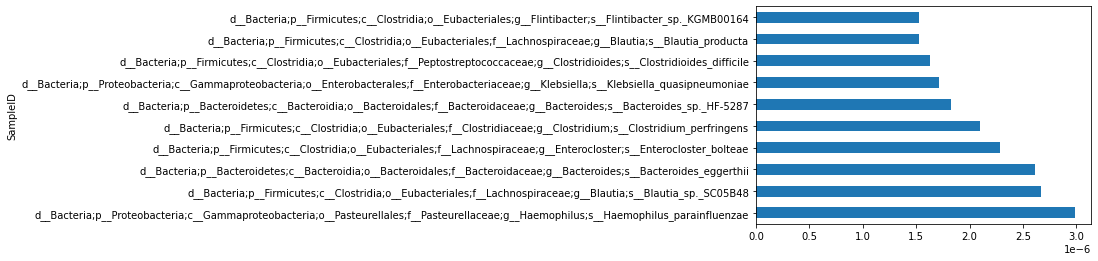

In [109]:
# Linear SVM
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel = 'linear', C = 2)
clf.fit(bacteria, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, bacteria, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.coef_[0]), index=bacteria_names).nlargest(10).plot(kind='barh')

Scores for each fold are: [0.75       1.         0.5        0.5        0.5        0.75
 1.         0.5        0.5        1.         0.75       0.75
 0.75       0.75       0.75       1.         0.5        1.
 0.75       0.33333333 0.75       0.75       0.75       0.75
 0.75       0.75       0.25       0.75       0.75       1.
 1.         0.5        0.75       0.75       0.5        0.5
 0.75       0.75       0.5        0.66666667 0.75       0.75
 0.5        0.75       0.25       1.         0.5        1.
 0.5        0.33333333]
Average score: 0.692


<AxesSubplot:ylabel='SampleID'>

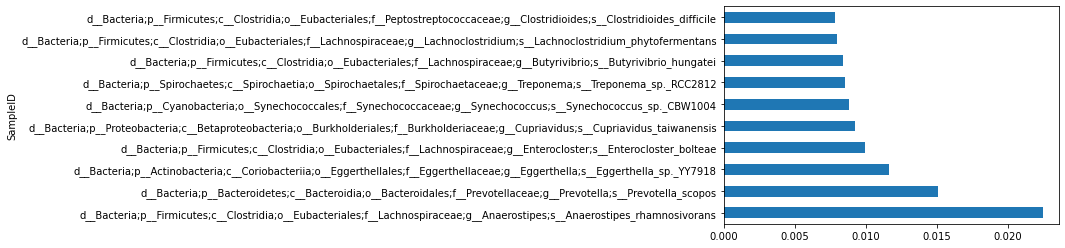

In [16]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(bacteria, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, bacteria, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=bacteria_names).nlargest(10).plot(kind='barh')

In [17]:
# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(bacteria, y):
    
    model = Sequential([
        Dense(1000, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["AUC", "binary_accuracy"])
    
    model.fit(bacteria[train], y[train],
              epochs = 100,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(bacteria[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} \ntrain {:s}: {:.2%}".format(model.metrics_names[1], train_result[1],
                                               model.metrics_names[2], train_result[2]))
    
    result = model.evaluate(bacteria[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1],
                                               model.metrics_names[2], result[2]))
    cvacc.append(result[2])
    cvauc.append(result[1])
print("Accuracy: {:.2%} (+/-{:.2%}) \nAUC: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc),
                                                      np.mean(cvauc), np.std(cvauc)))

train auc: 99.18% 
train binary_accuracy: 82.86%

auc: 50.00% 
binary_accuracy: 75.00% 

train auc: 93.63% 
train binary_accuracy: 80.00%

auc: 50.00% 
binary_accuracy: 25.00% 

train auc: 100.00% 
train binary_accuracy: 82.86%

auc: 50.00% 
binary_accuracy: 25.00% 

train auc: 92.32% 
train binary_accuracy: 80.00%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 98.69% 
train binary_accuracy: 91.43%

auc: 50.00% 
binary_accuracy: 25.00% 

train auc: 100.00% 
train binary_accuracy: 91.43%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 94.12% 
train binary_accuracy: 77.14%

auc: 100.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 80.00%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 87.25% 
train binary_accuracy: 82.86%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 89.66% 
train binary_accuracy: 75.00%

auc: 100.00% 
binary_accuracy: 66.67% 

Accuracy: 46.67% (+/-16.33%) 
AUC: 60.00% (+/-20.00%)


## Combined Expressed Taxa Data Analysis

In [17]:
# combine data
combined = np.array(np.hstack([fungi, bacteria]))
combined.shape

(39, 7440)

In [112]:
# Linear SVM
from sklearn import svm
from sklearn import metrics

svm = svm.SVC(kernel = 'linear', C = 2)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(svm, combined, y, scoring='accuracy', cv=cv)
# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

Scores for each fold are: [0.75       1.         0.25       0.5        0.75       0.5
 1.         0.5        0.5        1.         0.75       0.75
 0.75       0.5        1.         0.75       0.25       0.5
 0.75       0.66666667 0.75       0.75       0.75       0.75
 1.         0.75       0.75       0.5        0.25       0.66666667
 1.         0.5        0.5        0.75       0.75       0.5
 0.75       0.75       0.75       0.66666667 1.         0.75
 0.75       0.75       0.5        0.75       0.25       0.25
 0.75       1.        ]
Average score: 0.680


In [34]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(combined, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, combined, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

Scores for each fold are: [0.75       1.         0.5        0.75       0.5        0.5
 1.         0.75       0.5        0.66666667 0.75       0.75
 0.75       0.5        1.         1.         0.5        1.
 0.5        0.33333333 0.75       0.75       0.5        0.75
 0.75       0.75       0.25       0.75       0.75       1.
 1.         0.5        0.75       0.75       1.         0.5
 0.75       0.75       0.5        1.         1.         0.75
 0.75       0.75       0.25       1.         0.75       1.
 0.75       0.33333333]
Average score: 0.717


In [27]:
# combined network:

# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(combined, y):
    
    model = Sequential([
        Lambda(lambda x: K.log(K.cast((1 + x * 1000), "float32"))/K.log(K.cast((1 + 1000), "float32"))),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["AUC", "binary_accuracy"])
    
    model.fit(combined[train], y[train],
              epochs = 1000,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(combined[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} \ntrain {:s}: {:.2%}".format(model.metrics_names[1], train_result[1],
                                               model.metrics_names[2], train_result[2]))
    
    result = model.evaluate(combined[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1],
                                               model.metrics_names[2], result[2]))
    cvacc.append(result[2])
    cvauc.append(result[1])
print("Accuracy: {:.2%} (+/-{:.2%}) \nAUC: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc),
                                                      np.mean(cvauc), np.std(cvauc)))

train auc: 83.66% 
train binary_accuracy: 77.14%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 94.77% 
train binary_accuracy: 74.29%

auc: 87.50% 
binary_accuracy: 50.00% 

train auc: 89.05% 
train binary_accuracy: 82.86%

auc: 0.00% 
binary_accuracy: 25.00% 

train auc: 98.69% 
train binary_accuracy: 65.71%

auc: 100.00% 
binary_accuracy: 50.00% 

train auc: 94.12% 
train binary_accuracy: 74.29%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 90.52% 
train binary_accuracy: 85.71%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 92.81% 
train binary_accuracy: 74.29%

auc: 100.00% 
binary_accuracy: 50.00% 

train auc: 93.14% 
train binary_accuracy: 82.86%

auc: 37.50% 
binary_accuracy: 50.00% 

train auc: 87.91% 
train binary_accuracy: 82.86%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 99.07% 
train binary_accuracy: 72.22%

auc: 25.00% 
binary_accuracy: 66.67% 

Accuracy: 49.17% (+/-9.46%) 
AUC: 55.00% (+/-30.72%)
